## Prepare lst file

In [12]:
## --list <prefix of lst file> <path-to-training-image>
!python /home/minshiu/mxnet/tools/im2rec.py --list train /home/minshiu/aws-lauretta-sagemaker-XRAY/train_weapon/

## Convert lst to object detection type

In [12]:
## 2  4  5  500  600  2  0.6  0.1  0.7  0.5  0  0.1  0.3  0.2  0.4  3  0.25  0.25  0.3  0.3 data/zzz.jpg
import os
import json
with open('train.lst', 'r') as f:
    lst = f.readlines()

final_data = ''
for idx, line in enumerate(lst):
    arr = line[:-1].split('\t')
    img = arr[-1]
    img_name_prefix = img[:img.rfind('.')]
    file_path_prefix = '/home/minshiu/aws-lauretta-sagemaker-XRAY/train_weapon_annotation/'
    with open(os.path.join(file_path_prefix, img_name_prefix + '.json'), 'r') as p:
        content = json.loads(p.readlines()[0])
    width = content['image_size'][0]['width']
    height = content['image_size'][0]['height']
    data = '\t'.join([str(idx), '4', '5', str(width), str(height)])
    for a in content['annotations']:
        xmin = round(a['left']/width, 4)
        xmax = round((a['left'] + a['width'])/width, 4)
        ymin = round(a['top']/height, 4)
        ymax = round((a['top'] + a['height'])/height, 4)
        data = '\t'.join([data, a['class_id'], str(xmin), str(ymin), str(xmax), str(ymax)])
    data = '\t'.join([data, '/home/minshiu/aws-lauretta-sagemaker-XRAY/train_weapon/' + img])
    final_data += data + '\n'
      
with open('train_revamped.lst', 'w+') as p:
    p.writelines(final_data)

## Generate rec file

In [14]:
## python im2rec.py --pack-label dataset.lst Dataset
#--pack-label  => when you have label
#dataset.lst     => name for .rec  type for your self in .lst
#Dataset       => DataSet image folder
!python /home/minshiu/mxnet/tools/im2rec.py --pack-label /home/minshiu/train_revamped.lst /home/minshiu/aws-lauretta-sagemaker-XRAY/train_weapon/

Creating .rec file from /home/minshiu/train_revamped.lst in /home/minshiu
multiprocessing not available, fall back to single threaded encoding
time: 0.058968305587768555  count: 0


## Convert yolo.txt annotation to json image format

In [77]:
import os
import cv2
import json
import numpy as np

with open('/home/minshiu/aws-lauretta-sagemaker-XRAY/XRaySamples/classes.txt', 'r') as ff:
    classes = ff.readlines()
classes = [c[:-1] for c in classes]

for file in filels:
    with open(file, 'r') as f:
        lines = f.readlines()
    imgf = file[:file.rfind('.')] + '.png'
    img = cv2.imread(imgf)
    height, width, depth = img.shape
    d = dict()
    d['image_size'] = [{'width': width, 'height': height, 'depth': 3}]
    d['file'] = imgf.split('/')[-1]
    annotation_ls = list()
    class_ls = list()
    class_ids = list()
    for l in lines:
        class_id, x, y, absw, absh = l[:-1].split(' ')
        #print(class_id, x, y, absw, absh)
        #print(float(x)*width, float(y)*height, float(absw)*width, float(absh)*height)
        xc = float(x)*width
        yc = float(y)*height
        w = float(absw)*width
        h = float(absh)*height
        left = xc - w/2
        top = yc - h/2
        #print(left, top, w, h)
        ann = {'left': int(left), 'top': int(top), 'width': int(w), 'height': int(h), 'class_id': class_id}
        annotation_ls.append(ann)
        if class_id not in class_ids:
            cls = {'class_id': class_id, 'name': classes[int(class_id)]}
            class_ls.append(cls)
            class_ids.append(class_id)
        #cv2.imshow('test', img[394:394+413, 1114:1114+71])
        #cv2.waitKey(0)
        #cv2.destroyAllWindows()
    d['annotations'] = annotation_ls
    d['categories'] = class_ls
    with open(imgf[:imgf.rfind('.')] + '.json', 'w') as p:
        json.dump(d, p)

## Convert labelbox json annotation to sagemaker json annotation

In [ ]:
## input: .json file(generated from labelbox export)
## output: one json file for one image

import os
import cv2
import json
import numpy as np

count = 0
synset_path = '/home/minshiu/aws-lauretta-sagemaker-XRAY/classes.txt'
with open(synset_path, 'r') as f:
    lines = f.readlines()
classes = [l[:-1] for l in lines]

number = np.arange(len(classes))
reference_list = dict(zip(classes, number))

file = '/home/minshiu/Downloads/export-2019-05-02T06_51_45.675Z.json'
with open(file, 'r') as f:
    lines = f.readlines()

raw_string = lines[0].split('"ID"')
del raw_string[0]
splitted = []

for idx, l in enumerate(raw_string):
    s = '''{"ID"''' + l[:-2]
    if int(idx) == len(raw_string) - 1:
        s += '}'
    splitted.append(json.loads(s))

for idx, item in enumerate(splitted):
    
    file = item.pop('External ID')
    filePath = '/home/minshiu/aws-lauretta-sagemaker-XRAY/' + file
    img = cv2.imread(filePath)
    
    if img is None:
        #print('Skipping file: {} \nReason: image not found'.format(file))
        continue
    
    print('Found image with annotation: {}'.format(file))
    
    (height, width, depth) = img.shape
    item['image_size'] = [{'width':width, 'height':height, 'depth':depth}]
    item['file'] = file
    ann_ls = []
    categories = []
    if item['Label'] == 'Skip':
        continue
    else:
        lbl = item['Label']
        for k in list(lbl.keys()):
            dct = lbl[k]
            for d in dct:
                ann = {}
                cls_name = list(d.values())[0]
                small_y = min(t['y'] for t in d['geometry'])
                large_y = max(t['y'] for t in d['geometry']
                large_x = max(t['x'] for t in d['geometry'])
                small_x = min(t['x'] for t in d['geometry'])
                ann['left'] = small_x
                ann['top'] = small_y
                ann['width'] = large_x - small_x
                ann['height'] = large_y - small_y
                if type(cls_name) != list:
                    if cls_name not in reference_list.keys():
                        reference_list[cls_name] = str(len(reference_list))
                    ann['class_id'] = str(reference_list[cls_name])
                else:
                    if k not in reference_list.keys():
                        reference_list[k] = str(len(reference_list))
                    ann['class_id'] = str(reference_list[k])
                ann_ls.append(ann)

        item["annotations"] = ann_ls
        x = [ids['class_id'] for ids in ann_ls]
        unique = np.unique(x)
        for u in unique:
            k = [key for key in reference_list.items() if str(key[1]) == str(u)][0][0]
            categories.append({"class_id": u, "name": k})
        item["categories"] = categories
    count += 1
    print(item, '\n')
    print('------------------------Done {} files.------------------------------'.format(count))
    
    keys = list(item.keys())[-4:]
    content = dict(zip([k for k in keys], [item[k] for k in keys]))
    jsonFile = item['file'].split('.')[0] + '.json'
    with open(os.path.join('/home/minshiu/aws-lauretta-sagemaker-XRAY/generated/', jsonFile), 'w') as p:
        json.dump(content, p)

In [33]:
reference_list ## Current detection list!

{'Electronic': 14,
 'Liquid': 17,
 'Opaque': 16,
 'Personal Item': 9,
 'cartridges': '19',
 'guns': 15,
 'handphone': 3,
 'key': 0,
 'knife': 6,
 'laptop': 8,
 'metal_pipes': 18,
 'other': 5,
 'other_electronic': 1,
 'other_item': 13,
 'other_liquid': 11,
 'other_weapon': 10,
 'powerbank': 7,
 'rifles': '20',
 'scissors': 12,
 'umbrella': 4,
 'water_bottle': 2}

## Generate image augmentation

In [15]:
import os
import cv2
import json
from imgaug import augmenters as iaa

MODE = 'lr'
#MODE = 'ud'

def aug(img, fliplr=False, flipud=False):

    sequential_list = []
    
    if fliplr:
        sequential_list.append(iaa.Fliplr(1))
    if flipud:
        sequential_list.append(iaa.Flipud(1))

    seq = iaa.Sequential(sequential_list, random_order=True)

    return seq.augment_image(img)  

path_annotation = '/home/minshiu/aws-lauretta-sagemaker-XRAY/train_weapon_annotation/'
path_image = '/home/minshiu/aws-lauretta-sagemaker-XRAY/train_weapon/'
path_annotation_out = '/home/minshiu/aws-lauretta-sagemaker-XRAY/train_weapon_aug_annotation/'
path_image_out = '/home/minshiu/aws-lauretta-sagemaker-XRAY/train_weapon_aug/'
fileList = os.listdir(path_annotation)

for file in fileList:
    filename = file[:file.rfind('.')]
    img = cv2.imread(os.path.join(path_image, filename + '.PNG'))
    if img is None:
        img = cv2.imread(os.path.join(path_image, filename + '.png'))
    fliplr = True if MODE=='lr' else False
    flipud = True if MODE=='ud' else False
    cv2.imwrite(path_image_out + filename + '_aug_' + MODE + '.PNG',
                aug(img, fliplr, flipud))
    with open(os.path.join(path_annotation, file), 'r') as f:
        txt = f.readlines()[0]
        js = json.loads(txt)
        img_h, img_w = img.shape[:2]
        js['image_size'] = [{'width': img_w, 'height': img_h, 'depth':3}]
        js['file'] = filename + '_aug_' + MODE + '.PNG'
        if MODE == 'ud':
            for a in js['annotations']:
                #x = a['left']
                y = a['top']
                #w = a['width']
                h = a['height']
                #a['left'] = img_w - a['left'] - w
                a['top'] = img_h - a['top'] - h
        if MODE == 'lr':
            for a in js['annotations']:
                x = a['left']
                #y = a['top']
                w = a['width']
                #h = a['height']
                a['left'] = img_w - a['left'] - w
                #a['top'] = img_h - a['top'] - h
    with open(os.path.join(path_annotation_out, filename + '_aug_' + MODE + '.json'), 'w') as p:
        json.dump(js, p)
    print(js)

    print('-----------------------------------------------')

{'image_size': [{'width': 637, 'height': 764, 'depth': 3}], 'file': '6151655_20181231193513781_SCREENER_aug_lr.PNG', 'annotations': [{'left': 127, 'top': 203, 'width': 271, 'height': 110, 'class_id': '2'}, {'left': 77, 'top': 218, 'width': 47, 'height': 161, 'class_id': '5'}], 'categories': [{'class_id': '2', 'name': 'water_bottle'}, {'class_id': '5', 'name': 'other'}]}
-----------------------------------------------
{'image_size': [{'width': 566, 'height': 1100, 'depth': 3}], 'file': 'Screenshot 2019-03-21 at 3.25.39 PM_aug_lr.PNG', 'annotations': [{'left': 101, 'top': 247, 'width': 420, 'height': 667, 'class_id': '8'}], 'categories': [{'class_id': '8', 'name': 'laptop'}]}
-----------------------------------------------
{'image_size': [{'width': 512, 'height': 764, 'depth': 3}], 'file': '6151655_20190107124235968_SCREENER_aug_lr.PNG', 'annotations': [{'left': 368, 'top': 286, 'width': 104, 'height': 167, 'class_id': '3'}, {'left': 255, 'top': 271, 'width': 65, 'height': 90, 'class_id'

{'image_size': [{'width': 1696, 'height': 1184, 'depth': 3}], 'file': 'Screenshot 2019-03-21 at 3.22.33 PM_aug_lr.PNG', 'annotations': [{'left': 1025, 'top': 437, 'width': 118, 'height': 183, 'class_id': '15'}, {'left': 83, 'top': 264, 'width': 465, 'height': 687, 'class_id': '8'}], 'categories': [{'class_id': '15', 'name': 'guns'}, {'class_id': '8', 'name': 'laptop'}]}
-----------------------------------------------
{'image_size': [{'width': 1088, 'height': 1168, 'depth': 3}], 'file': 'Screenshot 2019-03-21 at 3.25.06 PM_aug_lr.PNG', 'annotations': [{'left': 181, 'top': 707, 'width': 401, 'height': 46, 'class_id': '6'}, {'left': 651, 'top': 316, 'width': 221, 'height': 400, 'class_id': '6'}, {'left': 112, 'top': 391, 'width': 69, 'height': 260, 'class_id': '7'}, {'left': 800, 'top': 311, 'width': 95, 'height': 243, 'class_id': '7'}], 'categories': [{'class_id': '6', 'name': 'knife'}, {'class_id': '7', 'name': 'powerbank'}]}
-----------------------------------------------
{'image_size'

{'image_size': [{'width': 1020, 'height': 1068, 'depth': 3}], 'file': 'Screenshot 2019-03-21 at 3.21.41 PM_aug_lr.PNG', 'annotations': [{'left': 865, 'top': 346, 'width': 51, 'height': 406, 'class_id': '6'}], 'categories': [{'class_id': '6', 'name': 'knife'}]}
-----------------------------------------------
{'image_size': [{'width': 1150, 'height': 964, 'depth': 3}], 'file': 'Screenshot 2019-03-21 at 3.24.02 PM_aug_lr.PNG', 'annotations': [{'left': 315, 'top': 490, 'width': 435, 'height': 163, 'class_id': '6'}], 'categories': [{'class_id': '6', 'name': 'knife'}]}
-----------------------------------------------
{'image_size': [{'width': 359, 'height': 1064, 'depth': 3}], 'file': '6132221_20190315125705859_SCREENER_aug_lr.PNG', 'annotations': [{'left': 47, 'top': 542, 'width': 264, 'height': 168, 'class_id': '21'}], 'categories': [{'class_id': '21', 'name': 'cartridges'}]}
-----------------------------------------------
{'image_size': [{'width': 1864, 'height': 1124, 'depth': 3}], 'file'

## Configuration of mxnet model to make it deployable when offline

In [1]:
import mxnet as mx
import numpy as np

# **model shd be at deployment mode
network_prefix = '/home/minshiu/aws-lauretta-sagemaker-XRAY/model/detector3'
label_names = ['label']

# Load the network parameters from default epoch 0
sym, arg_params, aux_params = mx.model.load_checkpoint(network_prefix, 0)

# Load the network into an MXNet module and bind the corresponding parameters
mod = mx.mod.Module(symbol=sym, label_names=label_names, context=mx.gpu(0))
mod.bind(for_training=False, data_shapes=[('data', (1,3,512,512))])
mod.set_params(arg_params, aux_params)

/home/minshiu/anaconda3/lib/python3.6/site-packages/mxnet/module/base_module.py:55: UserWarning: You created Module with Module(..., label_names=['label']) but input with name 'label' is not found in symbol.list_arguments(). Did you mean one of:
	relu4_3_scale
	data
  warnings.warn(msg)
/home/minshiu/anaconda3/lib/python3.6/site-packages/mxnet/module/base_module.py:67: UserWarning: Data provided by label_shapes don't match names specified by label_names ([] vs. ['label'])
  warnings.warn(msg)


## Deploy mxnet model locally and make prediction

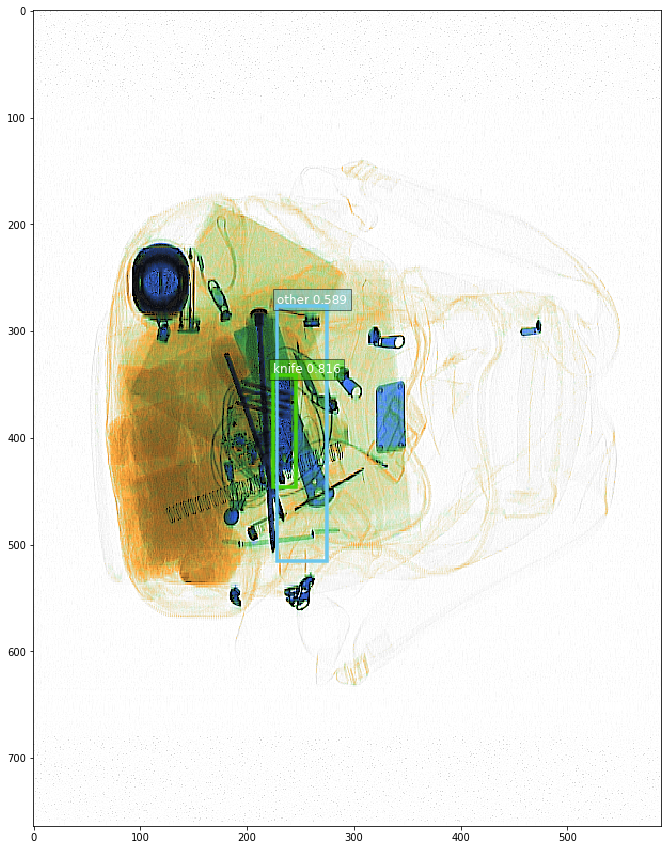

In [5]:
%matplotlib inline
import cv2
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from collections import namedtuple

Batch = namedtuple('Batch', ['data'])
img_file = '/home/minshiu/aws-lauretta-sagemaker-XRAY/train_weapon_aug_with_footage/6151655_20190104100042625_SCREENER.PNG'
img = cv2.cvtColor(cv2.imread(img_file), cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (512,512))
img = np.swapaxes(img, 0, 2)
img = np.swapaxes(img, 1, 2)
img = img[np.newaxis, :]

# Run forward on the image
mod.forward(Batch([mx.nd.array(img)]))
prob = mod.get_outputs()[0].asnumpy()
prob = np.squeeze(prob)

plt.rcParams['figure.figsize'] = [15, 15]

synset_path = '/home/minshiu/aws-lauretta-sagemaker-XRAY/classes.txt'
with open(synset_path, 'r') as f:
    lines = f.readlines()
classes = [l[:-1] for l in lines]

img = mpimg.imread(img_file)
plt.imshow(img)
height = img.shape[0]
width = img.shape[1]
colors = dict()
for det in prob:
    (klass, score, x0, y0, x1, y1) = det
    if klass == -1:
        continue
    if score < 0.3:
        break
    cls_id = int(klass)
    if cls_id not in colors:
        colors[cls_id] = (random.random(), random.random(), random.random())
    xmin = int(x0 * width)
    ymin = int(y0 * height)
    xmax = int(x1 * width)
    ymax = int(y1 * height)
    rect = plt.Rectangle((xmin, ymin), xmax - xmin,
                         ymax - ymin, fill=False,
                         edgecolor=colors[cls_id],
                         linewidth=3.5)
    class_name = classes[cls_id]
    plt.gca().add_patch(rect)
    plt.gca().text(xmin, ymin - 2,
                    '{:s} {:.3f}'.format(class_name, score),
                    bbox=dict(facecolor=colors[cls_id], alpha=0.5),
                            fontsize=12, color='white')

In [3]:
prob

array([[ 6.        ,  0.08453284,  0.19395515,  0.9205393 ,  0.29374316,
         0.970349  ],
       [-1.        ,  0.08453284,  0.17833015,  0.9205393 ,  0.27811816,
         0.970349  ],
       [-1.        ,  0.08453284,  0.16270515,  0.9205393 ,  0.26249316,
         0.970349  ],
       ...,
       [-1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        ],
       [-1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        ],
       [-1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        ]], dtype=float32)

## Stream and return prediction using socket

In [15]:
import cv2
import time
import json
import base64
import pickle
import socketio
import mxnet as mx
import numpy as np
from collections import namedtuple

def handleBoundaries(val, maxval):
    return 0 if val < 0 else int(maxval) if val > maxval else val

# standard Python
sio = socketio.Client()

#sio.connect('http://192.168.1.49:3000')
synset_path = '/home/minshiu/aws-lauretta-sagemaker-XRAY/classes.txt'
with open(synset_path, 'r') as f:
    lines = f.readlines()
classes = [l[:-1] for l in lines]

# **model shd be at deployment mode
network_prefix = '/home/minshiu/mxnet/example/ssd/deploy_mobilenet-xray-detector_mobilenet_v2_300'
label_names = ['label']

# Load the network parameters from default epoch 0
sym, arg_params, aux_params = mx.model.load_checkpoint(network_prefix, 500)

# Load the network into an MXNet module and bind the corresponding parameters
mod = mx.mod.Module(symbol=sym, label_names=label_names, context=mx.gpu(0))
mod.bind(for_training=False, data_shapes=[('data', (1,3,512,512))])
mod.set_params(arg_params, aux_params)
Batch = namedtuple('Batch', ['data'])

vid = cv2.VideoCapture('/home/minshiu/Downloads/video.mp4')
frame_skipping = 0.5
current_time = time.time()

while True:
    
    ret, frame = vid.read()
    
    if not ret:
        break
    
    height, width, _ = frame.shape
    if time.time() - current_time > frame_skipping:
        current_time = time.time() 
        img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (512,512))
        img = np.swapaxes(img, 0, 2)
        img = np.swapaxes(img, 1, 2)
        img = img[np.newaxis, :]
        print('Results:')

        mod.forward(Batch([mx.nd.array(img)]))
        prob = mod.get_outputs()[0].asnumpy()
        prob = np.squeeze(prob)
        
        predictions = list()
        for det in prob:
            (klass, score, x1, y1, x2, y2) = det
            if klass == -1:
                continue
            if score < 0.05:
                break
            class_name = classes[int(klass)]
            
            xmin = handleBoundaries(int(x1*width)-30, width) 
            ymin = handleBoundaries(int(y1*height)-30, height)
            xmax = handleBoundaries(int(x2*width)+30, width) 
            ymax = handleBoundaries(int(y2*height)+30, height)
            
            detected_frame = frame[ymin:ymax, xmin:xmax]
            retval, buffer = cv2.imencode('.jpg', detected_frame)
            jpg_as_text = base64.b64encode(buffer)
            print(class_name, score)
            #sio.emit('message', data=(class_name, str(int(round(score*100))), 'hehe'))  
            #sio.emit('data', data={'weapon': class_name, 'percentage': str(int(round(score*100))),
            #                          'img':jpg_as_text.decode()})    


sio.disconnect()
vid.release()

/home/minshiu/anaconda3/lib/python3.6/site-packages/mxnet/module/base_module.py:55: UserWarning: You created Module with Module(..., label_names=['label']) but input with name 'label' is not found in symbol.list_arguments(). Did you mean one of:
	data
  warnings.warn(msg)
/home/minshiu/anaconda3/lib/python3.6/site-packages/mxnet/module/base_module.py:67: UserWarning: Data provided by label_shapes don't match names specified by label_names ([] vs. ['label'])
  warnings.warn(msg)


Results:
knife 0.13945031
knife 0.12603936
knife 0.109860905
knife 0.10675613
knife 0.10596321
knife 0.10442003
knife 0.09851694
knife 0.09761675
knife 0.09479444
knife 0.09450627
knife 0.09432741
knife 0.09394591
knife 0.093485616
knife 0.0904635
knife 0.0899131
knife 0.08896235
knife 0.0867892
knife 0.08358616
knife 0.083494514
knife 0.08322281
knife 0.08069991
knife 0.07959005
knife 0.0780054
knife 0.07787973
knife 0.07664226
knife 0.07664056
knife 0.07646525
knife 0.075482726
knife 0.07506738
knife 0.07485664
knife 0.07478994
knife 0.07363574
knife 0.072679855
knife 0.07266538
knife 0.07135165
knife 0.06986528
knife 0.06698128
knife 0.06613562
knife 0.066126905
knife 0.06532663
knife 0.065277524
knife 0.064909145
knife 0.0630633
knife 0.06300736
knife 0.059807725
knife 0.059511226
knife 0.059370086
knife 0.059100915
knife 0.05903517
knife 0.05872935
knife 0.05807031
knife 0.0576491
knife 0.057528842
knife 0.05676274
knife 0.056602452
knife 0.056445196
knife 0.056360718
knife 0.0561

Results:
knife 0.13953702
knife 0.10087643
knife 0.098901995
knife 0.09541458
knife 0.08995189
knife 0.08786025
knife 0.08305659
knife 0.080650456
knife 0.07934362
knife 0.07909679
knife 0.077551134
knife 0.07722602
knife 0.076205
knife 0.07559685
knife 0.07336793
knife 0.07251204
knife 0.07184765
knife 0.06959192
knife 0.06943448
knife 0.068679966
knife 0.06847444
knife 0.06845706
knife 0.06809839
knife 0.067718014
knife 0.06655861
knife 0.06526743
knife 0.064759575
knife 0.0644685
knife 0.06438014
knife 0.06416181
knife 0.0638557
knife 0.063759774
knife 0.062002305
knife 0.061879072
knife 0.06149133
knife 0.061312076
knife 0.061272163
knife 0.06092505
knife 0.06012187
knife 0.059386905
knife 0.059305195
knife 0.059151202
knife 0.058537938
knife 0.05790849
knife 0.057821367
knife 0.056028485
knife 0.05583671
knife 0.05575352
knife 0.05515908
knife 0.054049846
knife 0.053776644
knife 0.052884664
knife 0.05090916
knife 0.050496403
knife 0.050027166


In [8]:
prob

array([[ 0.        ,  0.09921308,  0.6349612 ,  0.57288504,  0.7413071 ,
         0.694855  ],
       [ 0.        ,  0.09567654,  0.37236187,  0.6611374 ,  0.4304265 ,
         0.7105374 ],
       [ 0.        ,  0.09414712,  0.75079256,  0.56689507,  0.8603923 ,
         0.68689865],
       ...,
       [-1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        ],
       [-1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        ],
       [-1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        ]], dtype=float32)